In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
import numpy as np
from random import randint

In [2]:
class Task():

  def __init__(self, batch_size=32, length=25, size=1):
        self.batch_size = batch_size
        self.length = length
        self.size = size

  def generate_sample(self, length = None):
    length = (length or self.length)

    context = list(np.random.choice(np.arange(0, 9), 2, replace=False))

    sequence = [randint(0,9) for _ in range(length)]

    target = 0 if sequence.count(context[0]) > sequence.count(context[1]) else 1

    sequence_final = []

    for element in sequence:
      copy_context = context.copy()
      copy_context.append(element)

      sequence_final.append(tf.reshape(tf.one_hot(copy_context, 10), (30)))

    return tf.squeeze(tf.convert_to_tensor(sequence_final)), target
    

  def generate_batch(self, length=None, batch_size=None, size=None):
    length = (length or self.length)
    batch_size = (batch_size or self.batch_size)
    size = (size or self.size)

    batch = [self.generate_sample(length) for _ in range(batch_size)]

    samples, targets = zip(*[(sample[0], sample[1]) for sample in batch])

    return tf.convert_to_tensor(samples), targets


task = Task()
samples, targets = task.generate_batch()

print(samples.shape)
print(len(targets))

(32, 25, 30)
32


In [3]:
class LSTM_Cell(tf.keras.Model):

  def __init__(self, hidden_size):
        super(LSTM_Cell, self).__init__()
        self.input_gate = tf.keras.layers.Dense(hidden_size, activation=tf.keras.activations.sigmoid)
        self.forget_gate = tf.keras.layers.Dense(hidden_size, activation=tf.keras.activations.sigmoid, bias_initializer="ones")
        self.output_gate = tf.keras.layers.Dense(hidden_size, activation=tf.keras.activations.sigmoid)
        self.cell_state_candidates = tf.keras.layers.Dense(hidden_size, activation=tf.keras.activations.tanh)

  def call(self, input, states):
        hidden_state = states[0]
        cell_state = states[1]

        concat_input = tf.concat([hidden_state, input], axis=2)
        cell_state = tf.multiply(cell_state, self.forget_gate(concat_input))
        update = tf.multiply(self.input_gate(concat_input), self.cell_state_candidates(concat_input))
        cell_state = tf.add(cell_state, update)
        output = tf.multiply(tf.keras.activations.tanh(cell_state), self.output_gate(concat_input))

        return (output, cell_state)

In [4]:
class LSTM(tf.keras.Model):
  def __init__(self, hidden_size):
    super(LSTM, self).__init__()
    self.cell = LSTM_Cell(hidden_size)

    self.hidden_size = hidden_size

  def call(self, batch, states):
    predictions = []

    for sequence in batch:

      for input in sequence:

        input = tf.expand_dims(tf.expand_dims(input, 0), 0)

        states = self.cell(input, states)

      predictions.append(states[0])

    predictions = tf.squeeze(tf.convert_to_tensor(predictions))

    return predictions

In [5]:
class LSTM_Model(tf.keras.Model):
  def __init__(self, hidden_size):
    super(LSTM_Model, self).__init__()
    self.hidden_size = hidden_size

    self.input_layer = tf.keras.layers.Dense(self.hidden_size, activation=tf.keras.activations.sigmoid)
    self.lstm = LSTM(self.hidden_size)
    self.output_layer = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)

  def init_states(self):

    return (tf.zeros((1,1,self.hidden_size)), tf.zeros((1,1,self.hidden_size)))

  def call(self, x, states):
    x = self.input_layer(x)
    x = self.lstm(x, states)
    x = self.output_layer(x)

    return x
    

# Training

In [6]:
def train_step(model, input, target, loss_function, optimizer):
    
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        zero_state = model.init_states()
        prediction = model(input,zero_state)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    target = np.array([[[target_s] for target_s in list(target)]])
    prediction = tf.expand_dims(prediction, 0)

    # accuracy using a 0.5 threshold
    acc = np.sum(np.abs((target-prediction))<0.5)/(target.shape[0]*target.shape[1])

    return np.mean(loss), acc

In [7]:
def train(model, task, steps=100, print_every=10, running_average_factor = 0.95):
    
    optimizer = tf.keras.optimizers.Adam()
    cross_entropy_loss = tf.keras.losses.MSE

    losses = []
    acces = []

    running_average_loss = 0
    running_average_acc = 0
    i=0

    for i in range(steps):
        # generating a new sample in each training step
        sequence, target = task.generate_batch()
        loss, acc = train_step(model, sequence, target, cross_entropy_loss, optimizer)
        
        # compute the running averages of training loss and accuracy
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * loss
        running_average_acc = running_average_factor * running_average_acc  + (1 - running_average_factor) * acc
        losses.append(running_average_loss)
        acces.append(running_average_acc)
        
        if i%print_every==0:
            print(f"Training step {i}: average loss is {np.round(losses[-1],2)}, accuracy of {np.round(acces[-1], 2)} %")
        
        if i == steps:
            break
        i+=1
    
    return losses, acces

In [8]:
def visualize(losses, acces, name=''):
    plt.figure()
    plt.title(name)
    line1, = plt.plot(losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.show()
    plt.figure()
    line1, = plt.plot(acces)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.show()

Training step 0: average loss is 0.01, accuracy of 0.03 %
Training step 10: average loss is 0.11, accuracy of 0.24 %
Training step 20: average loss is 0.16, accuracy of 0.38 %
Training step 30: average loss is 0.2, accuracy of 0.49 %
Training step 40: average loss is 0.22, accuracy of 0.52 %
Training step 50: average loss is 0.23, accuracy of 0.55 %
Training step 60: average loss is 0.24, accuracy of 0.55 %
Training step 70: average loss is 0.24, accuracy of 0.57 %
Training step 80: average loss is 0.24, accuracy of 0.59 %
Training step 90: average loss is 0.24, accuracy of 0.58 %


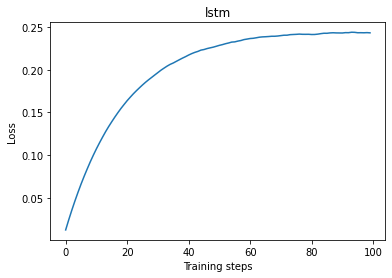

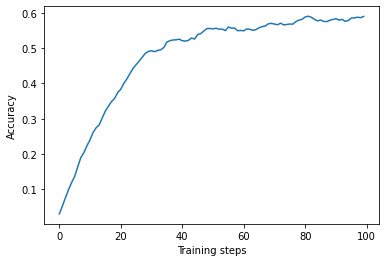

In [9]:
model = LSTM_Model(hidden_size = 2)
task = Task(length=25)
losses, acces = train(model, task)
visualize(losses, acces, 'lstm')